In [1]:
"""" 
The current velocity of 2023's SD-1042 has a mean 37.4 degree angle from those on the nearby buoy 42022 in eastern GoM
or mean of 12 degree clockwise from buoy velocity to SD velocity
check bottom track test of SD-1042 to ensure the current velocity's data quality of SD-1042
--> Main goal here: Look at the straight passes.
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
import math
from numpy.linalg import norm
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_dir import vector_dir_to_from

In [2]:
### Info of SD-1042's merged adcp data
year = '2023'
platf_num = '1042'
path_cur_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
tlim_plot = [datetime.datetime(int(year),10,24), datetime.datetime(int(year),10,25)] ### 2023 SD1042
tint = 3
nt_plot = int((tlim_plot[1]-tlim_plot[0]).days*24/tint)
tticks = [tlim_plot[0]+datetime.timedelta(hours=3*i) for i in range(nt_plot)]
tticks_label = [tticks[i].strftime('%m/%d %H') for i in range(len(tticks))]
print(tticks_label)
### load adcp data
ds_cur_SD = nc.Dataset(path_cur_SD+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_cur_SD.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
vars_str = ['longitude','latitude','bt_vel_east','bt_vel_north','vehicle_vel_east','vehicle_vel_north']
for i in range( len(vars_str) ):
    temp = ds_cur_SD.variables[vars_str[i]][:]
    temp.filled(np.nan)
    exec( vars_str[i]+' = temp')
del time

['10/24 00', '10/24 03', '10/24 06', '10/24 09', '10/24 12', '10/24 15', '10/24 18', '10/24 21']


In [6]:
### Read (From Mule) the navigation variables: SOG (speed over groud), COG (course over ground), ROLL (vechile heading, vechile yaw angle), 
# Roll (platform roll angle), Pitch (platform pitch angle)
str_vars = ['time','HDG','HDG_FILTERED_MEAN','ROLL_FILTERED_MEAN','PITCH_FILTERED_MEAN','SOG']
path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_'+year+'/delayed_post_mission/sd-'+platf_num+'/'
filenames_all = np.sort( os.listdir(path) )
filenames = np.array([])
for file in filenames_all: ### look for days of 10/24 - BT testing period
    if (year+'1024' in file) & ('.nc' in file):
        filenames = np.append(filenames, file)
print(filenames)
### append variables
for i in range( len(filenames) ):
    ds_airsea = nc.Dataset(path+filenames[i])
    for str_var_i in str_vars:
        data_append = np.squeeze( ds_airsea.variables[str_var_i][:] )
        # print(filenames[i],str_var_i, data_append.size)
        if i == 0:
            str_exec = str_var_i+'= data_append'
        else:
            str_exec = str_var_i+'= np.append('+str_var_i+',data_append)'
        exec(str_exec)
    ds_airsea.close()
###
dtime_nav = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=sec) for sec in time])

['saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T000000-20231024T015959-1_minutes-v1.1703005523835.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T020000-20231024T035959-1_minutes-v1.1703005524604.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T040000-20231024T055959-1_minutes-v1.1703005525376.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T060000-20231024T075959-1_minutes-v1.1703005526092.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T080000-20231024T095959-1_minutes-v1.1703005526914.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T100000-20231024T115959-1_minutes-v1.1703005527729.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T120000-20231024T135959-1_minutes-v1.1703005528600.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T140000-20231024T155959-1_minutes-v1.1703005529389.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231024T160000-20231024T175959-1_min

In [23]:
print(dtime_nav[0:3],dtime_nav[-1])

[datetime.datetime(2023, 10, 24, 0, 0)
 datetime.datetime(2023, 10, 24, 0, 1)
 datetime.datetime(2023, 10, 24, 0, 2)] 2023-10-24 23:59:00


Text(0.5, 1.0, 'V$_{BT}$ to -V$_{veh.}$ ($^o$) positive CW')

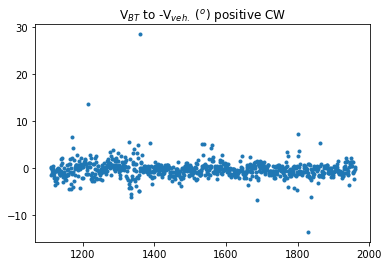

In [16]:
### compute the velocity direction
vehicle_vel_dir_to = np.nan*np.ones( dtime_cur_SD.shape )
bt_vel_dir_to = vehicle_vel_dir_to.copy()
for i in range( len(dtime_cur_SD) ):
    vehicle_vel_dir_to[i],_ = vector_dir_to_from(vehicle_vel_east[i], vehicle_vel_north[i])
    bt_vel_dir_to[i],_ = vector_dir_to_from(bt_vel_east[i], bt_vel_north[i])
### degrees between bt direction & opposite of vehicle direction to
# (positive degree from the opposite of vehicle headed direction to bt velocity headed direction)
deg_bt_to_negveh_clockwise = bt_vel_dir_to-((vehicle_vel_dir_to-180)%360)
deg_bt_to_negveh_clockwise[deg_bt_to_negveh_clockwise> 180] = deg_bt_to_negveh_clockwise[deg_bt_to_negveh_clockwise> 180]-360
deg_bt_to_negveh_clockwise[deg_bt_to_negveh_clockwise< -180] = deg_bt_to_negveh_clockwise[deg_bt_to_negveh_clockwise< -180]+360
plt.plot(deg_bt_to_negveh_clockwise,'.')
plt.title('V$_{BT}$ to -V$_{veh.}$ ($^o$) positive CW')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

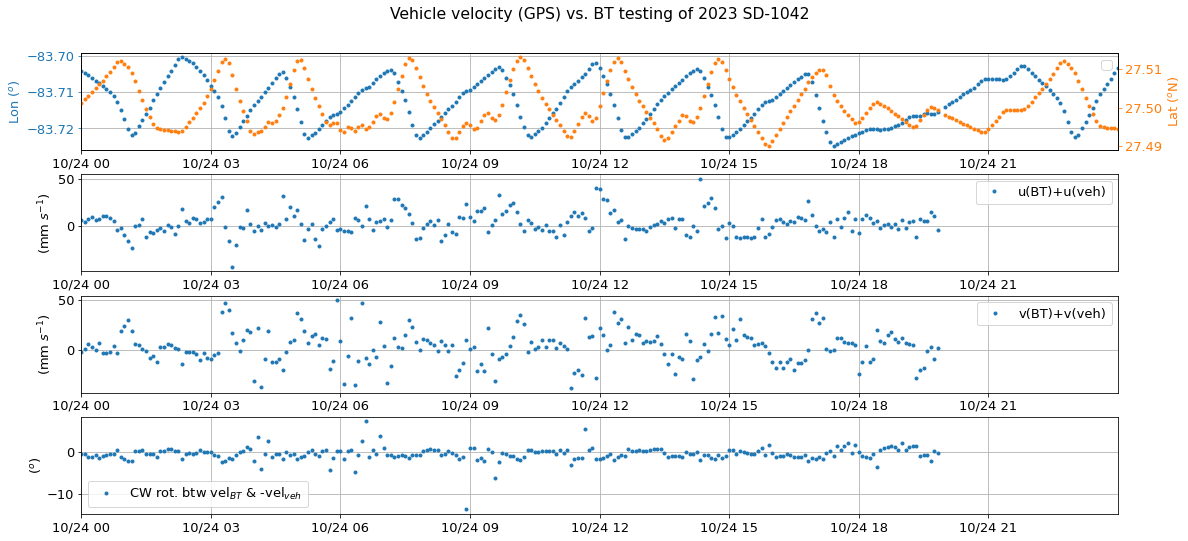

In [19]:
### plot bottom track velocity vs. vehicle velocity (determined by GPS -- assumed to be correct)
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD<= tlim_plot[1]))[0]
nrow = 4
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrow,1)
fig.set_size_inches(18, 8)
### lon/ lat
plt.subplot(nrow,1,1)
col = ['tab:blue','tab:orange']
ax0 = ax[0]
ax1 = ax0.twinx()
ax0.plot(dtime_cur_SD[it], longitude[it],'.',ms=6,color=col[0])
ax0.set_ylabel('Lon ($^o$)')
ax1.plot(dtime_cur_SD[it], latitude[it],'.',ms=6,color=col[1])
ax1.set_ylabel('Lat ($^o$N)')
### color settings
for i in range( len(col) ):
    ax_str = 'ax'+str(i); col_i = 'col[i]'
    exec(ax_str+'.yaxis.label.set_color('+col_i+')')
    exec(ax_str+'.tick_params(axis="y",colors='+col_i+')')
### u(BT)+u(veh)
plt.subplot(nrow,1,2)
du = (bt_vel_east+vehicle_vel_east)
plt.plot(dtime_cur_SD[it], du[it],'.',ms=6,label='u(BT)+u(veh)')
plt.legend(ncol=2,loc='best')
### arctan2 of vel(BT+veh)
dv = (bt_vel_north+vehicle_vel_north)
plt.subplot(nrow,1,3)
plt.plot(dtime_cur_SD[it], dv[it],'.',ms=6,label='v(BT)+v(veh)')
### degrees between bt direction & opposite of vehicle direction to (positive in )
plt.subplot(nrow,1,4)
plt.plot(dtime_cur_SD[it], deg_bt_to_negveh_clockwise[it],'.',ms=6,color=col[0],label='CW rot. btw vel$_{BT}$ & -vel$_{veh}$')

###
for i in range( nrow ):
    ax[i].set_xticks(tticks)
    ax[i].set_xticklabels(tticks_label)
    ax[i].set_xlim(tlim_plot)
    ax[i].grid()
    ax[i].legend(loc='best')
    if i == 1:
        ax[i].set_ylabel('(mm $s^{-1}$)')
    if i == 2:
        ax[i].set_ylabel('(mm $s^{-1}$)')
    if i == 3:
        ax[i].set_ylabel('($^o$)')
    
plt.suptitle('Vehicle velocity (GPS) vs. BT testing of '+year+' SD-'+platf_num)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.25)
### save to figure
# plt.savefig('timeseries_bt+veh_CW-rot-(bt&-veh)_cosine-similarity_'+year+'-SD'+platf_num+'_'+\
#             tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

Text(0.5, 0.98, '2023/10/24 00Ζ ~ 10/25 00Ζ')

<Figure size 432x288 with 0 Axes>

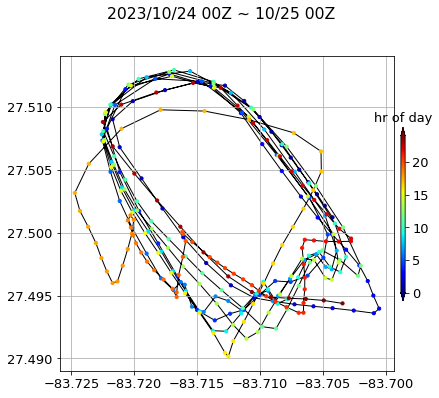

In [20]:
### plot SD location on map
# mday = np.array([(dtime_cur_SD[i]-datetime.datetime(int(year),10,1)).total_seconds()/86400+1 for i in range(len(dtime_cur_SD))])
# hour after tlim_plot[0]
hr_since_t0 = np.array([(dtime_cur_SD[i]-tlim_plot[0]).total_seconds()/3600 for i in range(len(dtime_cur_SD))])
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 6)
# sc = plt.scatter( longitude[it], latitude[it], c=mday[it], s=1, vmin=mday[it][0], vmax=mday[it][-1], cmap='jet')
plt.plot(longitude[it], latitude[it],color='k',lw=1,zorder=1)
sc = plt.scatter( longitude[it], latitude[it], c=hr_since_t0[it], s=10, \
                 vmin=hr_since_t0[it][0], vmax=hr_since_t0[it][-1], cmap='jet',zorder=2)
ax.set_aspect('equal', adjustable='box')
plt.grid()
cbar_ax = fig.add_axes([.915,.3,.01,.4])
axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
cbar_ax.set_title('hr of day',fontsize=13) # fraction day of the month
### save to figure
plt.suptitle(tlim_plot[0].strftime('%Y/%m/%d %HΖ ~ ')+tlim_plot[1].strftime('%m/%d %HΖ'))
# plt.savefig('scatter_lon-lat_c=hrofday_'+year+'-SD'+platf_num+'_'+\
#             tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

In [21]:
### compute the average, median, std, 10 & 90 percentile of the degree apart of BT+veh velocity
it = np.where( (dtime_cur_SD>= datetime.datetime(int(year),10,24)) & (dtime_cur_SD< datetime.datetime(int(year),10,25)) )[0]
y = deg_bt_to_negveh_clockwise[it]
perc = [5,95]
perc_y = np.percentile(y[~np.isnan(y)],perc)
print('=== stats of degree apart between BT velocity direction & opposite of vehicle velocity direction (positive clockwise) ===')
print( 'mean={:.2f}, median={:.2f}, std={:.2f}, \n{:.0f} & {:.0f} percentile = {:.2f}, {:.2f}'\
      .format(np.nanmean(y), np.nanmedian(y), np.nanstd(y), perc[0], perc[1], perc_y[0], perc_y[1]) )

=== stats of degree apart between BT velocity direction & opposite of vehicle velocity direction (positive clockwise) ===
mean=-0.51, median=-0.56, std=1.58, 
5 & 95 percentile = -2.13, 1.29


<Figure size 432x288 with 0 Axes>

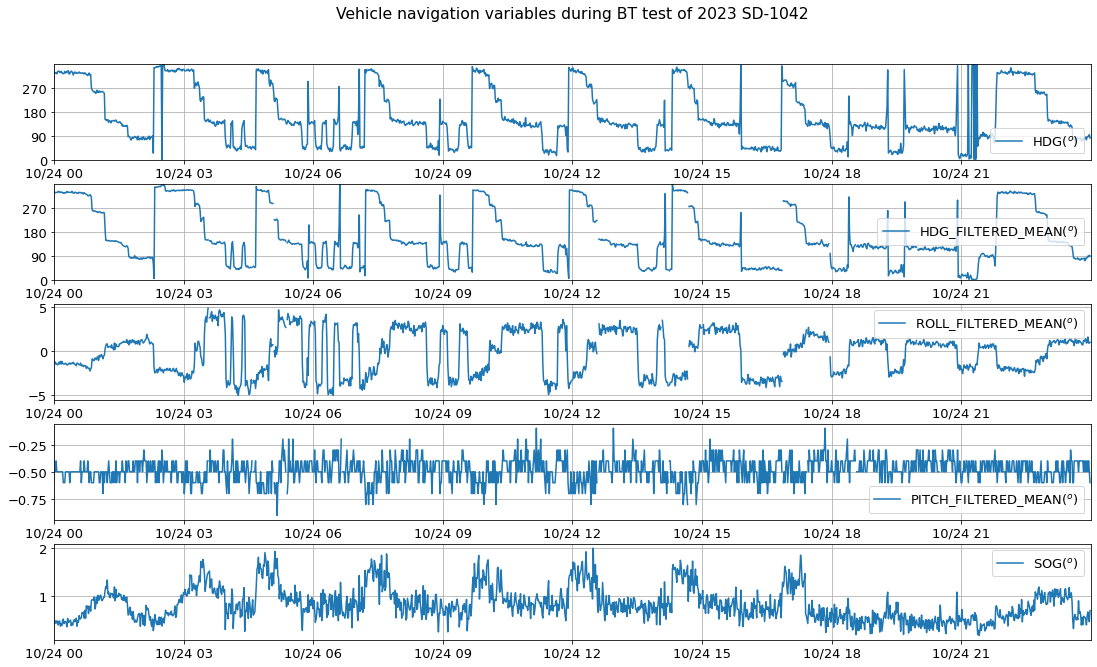

In [22]:
### plot nav variables
vars_plot = ['HDG','HDG_FILTERED_MEAN','ROLL_FILTERED_MEAN','PITCH_FILTERED_MEAN','SOG']
ylims_plot = [[0,360],[0,360],[],[],[]]
nrow = len(vars_plot)
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrow,1)
fig.set_size_inches(18, 10)
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.plot(dtime_nav, eval(vars_plot[i]),label=vars_plot[i]+'($^o$)')
    plt.xlim(tlim_plot)
    plt.grid()
    plt.legend(loc='best')
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label)
    if len(ylims_plot[i]) > 0:
        plt.ylim(ylims_plot[i])
        plt.yticks(np.arange(ylims_plot[i][0],ylims_plot[i][1],90))

plt.suptitle('Vehicle navigation variables during BT test of '+year+' SD-'+platf_num)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.25)
### save to figure
# plt.savefig('timeseries_HDG_ROLL_PITCH_SOG_'+year+'-SD'+platf_num+'_'+\
#             tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

0:02:30
=== stats of degree apart between BT velocity direction & opposite of vehicle velocity direction (positive clockwise) ===
mean=-0.45, median=-0.50, std=0.76, 
5 & 95 percentile = -1.47, 0.45


<Figure size 432x288 with 0 Axes>

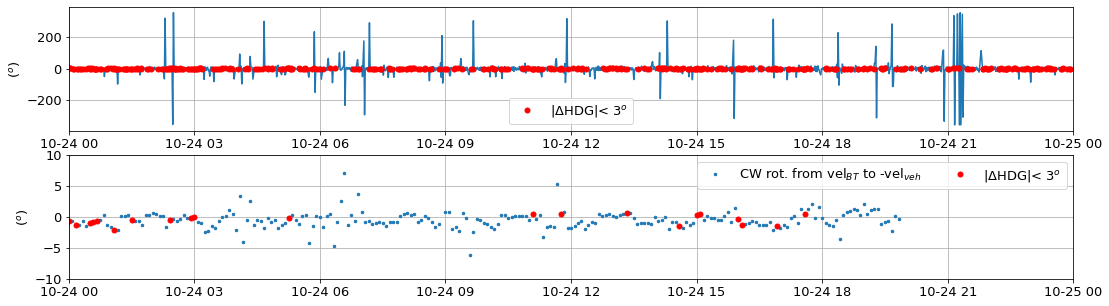

In [46]:
### plot timeseries of CW rotation from vel_BT to negative vel_vehicle. Look at straight passes (small HDG difference)
HDG_diff = np.diff( HDG )
HDG_crit = 3
dt_cur = datetime.timedelta(seconds=2.5*60); print(dt_cur)
###
nrow = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrow,1)
fig.set_size_inches(18, 5)
### (1) HDG vs |HDG_diff| < HDG_crit
plt.subplot(nrow,1,1)
# plt.hist( np.abs(HDG_diff),50)
plt.plot(dtime_nav[:-1], HDG_diff)
it_nav_small_HDG_diff = np.where( np.abs(HDG_diff) < HDG_crit )[0]
plt.plot(dtime_nav[:-1][it_nav_small_HDG_diff], HDG_diff[it_nav_small_HDG_diff],'o',ms=5,color='r',label='|\u0394HDG|< '+str(HDG_crit)+'$^o$')
### (2) deg_bt_to_negveh_clockwise
plt.subplot(nrow,1,2)
plt.plot(dtime_cur_SD, deg_bt_to_negveh_clockwise,'.',ms=5,label='CW rot. from vel$_{BT}$ to -vel$_{veh}$')
### go through dtime_cur_SD and find the times when the mean np.abs(HDF_diff) > HDG_crit
it_cur_ok_HDG = np.array([])
for i in range( len(dtime_cur_SD) ):
    it_temp = np.where( (dtime_nav>= dtime_cur_SD[i]-dt_cur) & (dtime_nav< dtime_cur_SD[i]+dt_cur) & (dtime_nav< dtime_nav[-1]) )[0]
    if len(it_temp) > 0:
        HDG_diff_abs_mn = np.nanmean( np.abs(HDG_diff[it_temp]) )
        if HDG_diff_abs_mn < HDG_crit:
            it_cur_ok_HDG = np.append( it_cur_ok_HDG, i)
it_cur_ok_HDG = it_cur_ok_HDG.astype(int)
plt.plot(dtime_cur_SD[it_cur_ok_HDG], deg_bt_to_negveh_clockwise[it_cur_ok_HDG],'o',ms=5,color='r',label='|\u0394HDG|< '+str(HDG_crit)+'$^o$')
plt.ylim([-10,10])
###
y = deg_bt_to_negveh_clockwise[it_cur_ok_HDG]
perc = [5,95]
perc_y = np.percentile(y[~np.isnan(y)],perc)
print('=== stats of degree apart between BT velocity direction & opposite of vehicle velocity direction (positive clockwise) ===')
print( 'mean={:.2f}, median={:.2f}, std={:.2f}, \n{:.0f} & {:.0f} percentile = {:.2f}, {:.2f}'\
      .format(np.nanmean(y), np.nanmedian(y), np.nanstd(y), perc[0], perc[1], perc_y[0], perc_y[1]) )

### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xlim(tlim_plot)
    plt.grid()
    plt.legend(loc='best',ncol=2)
    plt.ylabel('($^o$)')
### save to figure
# plt.savefig('timeseries_HDG-diff(cri={:.0f}deg)_CW-rot-(bt&-veh)_'.format(HDG_crit)+year+'-SD'+platf_num+'_'+\
#             tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

(array([1., 0., 0., 0., 2., 2., 0., 0., 2., 0., 2., 2., 1., 0., 3., 0., 0.,
        1., 4., 1.]),
 array([-2.1145884 , -1.97437412, -1.83415984, -1.69394557, -1.55373129,
        -1.41351701, -1.27330273, -1.13308845, -0.99287417, -0.8526599 ,
        -0.71244562, -0.57223134, -0.43201706, -0.29180278, -0.1515885 ,
        -0.01137422,  0.12884005,  0.26905433,  0.40926861,  0.54948289,
         0.68969717]),
 <BarContainer object of 20 artists>)

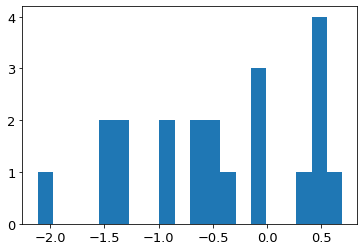

In [47]:
plt.hist(deg_bt_to_negveh_clockwise[it_cur_ok_HDG],20)

<Figure size 432x288 with 0 Axes>

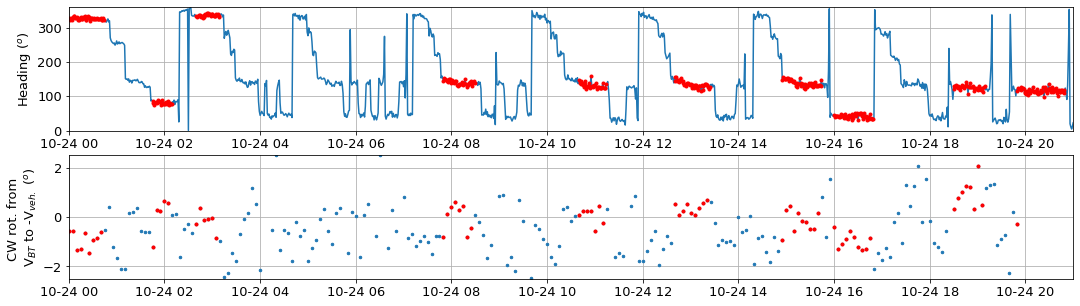

In [ ]:
'''hand pick a period of time when heading looks constant. 
Plot the deg_bt_to_negveh_clockwise of theses periods and compute stats'''
dtime_limits = [[datetime.datetime(int(year),10,24), datetime.datetime(int(year),10,24,0,45)],\
                [datetime.datetime(int(year),10,24,1,45), datetime.datetime(int(year),10,24,2,10)],\
                [datetime.datetime(int(year),10,24,2,40), datetime.datetime(int(year),10,24,3,10)],\
                [datetime.datetime(int(year),10,24,7,50), datetime.datetime(int(year),10,24,8,30)],\
                [datetime.datetime(int(year),10,24,10,40), datetime.datetime(int(year),10,24,11,15)],\
                [datetime.datetime(int(year),10,24,12,40), datetime.datetime(int(year),10,24,13,25)],\
                [datetime.datetime(int(year),10,24,14,55), datetime.datetime(int(year),10,24,15,45)],\
                [datetime.datetime(int(year),10,24,16,0), datetime.datetime(int(year),10,24,16,50)],\
                [datetime.datetime(int(year),10,24,18,30), datetime.datetime(int(year),10,24,19,10)],\
                [datetime.datetime(int(year),10,24,19,50), datetime.datetime(int(year),10,24,20,50)]]
nrow = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrow,1)
fig.set_size_inches(18, 5)
### Heading
plt.subplot(nrow,1,1)
plt.plot(dtime_nav, HDG)
it_cur_handpick_HDG = np.array([])
for i in range( len(dtime_limits) ):
    it_limit = np.where( (dtime_nav>= dtime_limits[i][0]) & (dtime_nav< dtime_limits[i][1]) )[0]
    plt.plot(dtime_nav[it_limit], HDG[it_limit],'r.')
    # print('Time length of this selected period:',dtime_limits[i][1]-dtime_limits[i][0])
    ### find the time indices for BT & current velocities.
    it_temp = np.where( (dtime_cur_SD>= dtime_limits[i][0]) & (dtime_cur_SD< dtime_limits[i][1]) )[0]
    if len(it_temp) > 0:
        it_cur_handpick_HDG = np.append(it_cur_handpick_HDG, it_temp)
it_cur_handpick_HDG = it_cur_handpick_HDG.astype(int)
plt.ylim([0,360])
plt.ylabel('Heading ($^o$)')    
### BT vel to -vehicle vel (positive CW)
plt.subplot(nrow,1,2)
plt.plot(dtime_cur_SD, deg_bt_to_negveh_clockwise,'.',ms=5,label='CW rot. from vel$_{BT}$ to -vel$_{veh}$')
plt.plot(dtime_cur_SD[it_cur_handpick_HDG], deg_bt_to_negveh_clockwise[it_cur_handpick_HDG],'r.')
plt.ylim([-2.5,2.5])
plt.ylabel('CW rot. from \nV$_{BT}$ to -V$_{veh.}$ ($^o$)')
###
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xlim([datetime.datetime(int(year),10,24),datetime.datetime(int(year),10,24,21)])
    plt.grid()
###
plt.savefig('timeseries_HDG-diff(cri={:.0f}deg)_CW-rot-(bt&-veh)_'.format(HDG_crit)+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_straight-passes.png',dpi=400,bbox_inches='tight')

=== stats of degree apart between BT velocity direction & opposite of vehicle velocity direction (positive clockwise) ===
mean=-0.13, median=-0.05, std=0.71, 
25 & 75 percentile = -0.67, 0.36


<Figure size 432x288 with 0 Axes>

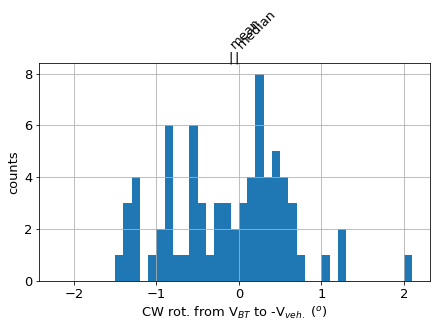

In [122]:
y = deg_bt_to_negveh_clockwise[it_cur_handpick_HDG]
perc = [25,75]
perc_y = np.percentile(y[~np.isnan(y)],perc)
print('=== stats of degree apart between BT velocity direction & opposite of vehicle velocity direction (positive clockwise) ===')
print( 'mean={:.2f}, median={:.2f}, std={:.2f}, \n{:.0f} & {:.0f} percentile = {:.2f}, {:.2f}'\
      .format(np.nanmean(y), np.nanmedian(y), np.nanstd(y), perc[0], perc[1], perc_y[0], perc_y[1]) )
###
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1)
fig.set_size_inches(7, 4)
plt.hist(deg_bt_to_negveh_clockwise[it_cur_handpick_HDG],bins=np.arange(-2.2,2.2,0.1))
plt.grid()
plt.xlabel('CW rot. from V$_{BT}$ to -V$_{veh.}$ ($^o$)')
plt.ylabel('counts')
###
y0,y1 = plt.gca().get_ylim()
plt.text(np.nanmedian(y), y1+0.01*(y1-y0),'|')
plt.text(np.nanmedian(y), y1+0.07*(y1-y0),'median',rotation=45)
plt.text(np.nanmean(y),y1+0.01*(y1-y0),'|')
plt.text(np.nanmean(y), y1+0.07*(y1-y0),'mean',rotation=45)
###
plt.savefig('hist_CW-rot-(bt&-veh)_'+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_straight-passes.png',dpi=400,bbox_inches='tight')